<a href="https://colab.research.google.com/github/farbodtaymouri/BERT-GAN/blob/main/Coding_test_Oracle_(OOS_task_GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torchvision import transforms, utils
import torch.nn as nn
from scipy.special import softmax
import torchvision
from torch.autograd import Variable
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=1000)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init  as init
import pandas as pd
import random
import pprint
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
import urllib.request, json 
import urllib, json
device=torch.device('cuda:0')
plt.style.use('ggplot')

In [ ]:
!pip install transformers
!pip install -U sentence-transformers
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import  AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

import warnings
warnings.filterwarnings('ignore')

Sat Oct 17 07:49:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    22W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Loading custom libraries
import sys
sys.path.append('/content/drive/My Drive/Deep Learing project')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading Json file
with urllib.request.urlopen('https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_imbalanced.json') as url:
    data = json.loads(url.read().decode())
    print(data)



In [ ]:
#Converting lists to pandas dataframe (creating unique category to numeric class labels)
def list_to_df(train,test,valid):
  tot_list = train+test+valid
  df = pd.DataFrame (tot_list,columns=['content', 'label'])
  num_labels = len(df['label'].unique())
  #Creating numerical class value
  df['label_num'] = pd.factorize(df.label)[0]

  train_df = df[0:len(train)]
  test_df = df[len(train): len(train)+len(test)]
  val_df = df[len(train)+len(test): len(train)+len(test)+len(valid)]

  return train_df, test_df, val_df, num_labels 

train_df, test_df, val_df, num_labels = list_to_df(data['oos_train']+data['train'], data['oos_test']+data['test'], data['oos_val']+data['val'])


oos_train_df = train_df[0:len(data['oos_train'])]
oos_test_df = test_df[0:len(data['oos_test'])]
oos_val_df = val_df[0:len(data['oos_val'])]
test_df = test_df[len(data['oos_test']):]
val_df = val_df[len(data['oos_val']):]


print("The number of classes:", num_labels)
print("Dim of train:", train_df.shape)
print("Dim of valid:", val_df.shape)
print("Dim of test", test_df.shape)
train_df.head(100)


The number of classes: 151
Dim of train: (10625, 3)
Dim of valid: (3000, 3)
Dim of test (4500, 3)


,content,label,label_num
0,how much is an overdraft fee for bank,oos,0
1,why are exponents preformed before multiplicat...,oos,0
2,what size wipers does this car take,oos,0
3,where is the dipstick,oos,0
4,how much is 1 share of aapl,oos,0
...,...,...,...
95,what percentage of species display cold bloode...,oos,0
96,what does it mean to be an alpha male,oos,0
97,what animals have alpha males,oos,0
98,why do males want to be alpha,oos,0


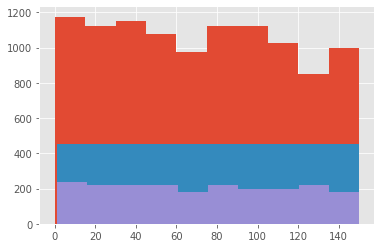

In [ ]:
#Class distributions across train.test, and validation sets
train_df['label_num'].hist()
test_df['label_num'].hist()
val_df['label_num'].hist()

In [ ]:
#Getting some insights about the sequence lengths
token_lens = []
tokens_list =[]

for txt in data['train']:
  tokens = tokenizer.encode(txt[0], truncation='only_first', max_length=50)
  token_lens.append(len(tokens))
  tokens_list.append(tokens)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


33

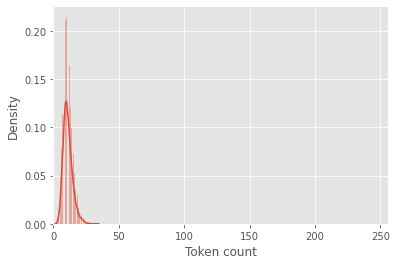

In [ ]:
data['train']
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
# from sentence_transformers import SentenceTransformer
# model_transformer = SentenceTransformer('distilbert-base-nli-mean-tokens')

100%|██████████| 245M/245M [00:03<00:00, 66.5MB/s]


In [ ]:
#Data model class class
class IntentDataset(Dataset):

  def __init__(self, reviews, targets, model):
    self.reviews = reviews  #A request
    self.targets = targets  # An Intent
    self.model = model
    # self.max_len = max_len
    # self.encoding =''

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.model.encode(
      review
    )
    return {
      #'review_text': review,
      #'input_ids': encoding['input_ids'].flatten(),
      'input_encoding': encoding,
      # 'attention_mask': encoding['attention_mask'].flatten(),
      # 'token_type_ids' : encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)

    }
#-----------------------------------------------
def create_data_loader(df, model, batch_size):
  ds = IntentDataset(
    reviews=df.content.to_numpy(),
    targets=df.label_num.to_numpy(),
    model=model,
  )

  #Returning a Pytorch tensor
  return DataLoader(
    ds,
    batch_size=batch_size,
    sampler = RandomSampler(ds), # Select batches randomly
    #num_workers=1
  )

In [ ]:
BATCH_SIZE = 16
oos_train_loader = create_data_loader(oos_train_df, model_transformer, BATCH_SIZE)
oos_val_loader = create_data_loader(oos_val_df, model_transformer, BATCH_SIZE)
oos_test_loader = create_data_loader(oos_test_df, model_transformer, BATCH_SIZE)


#train_loader = create_data_loader(train_df, model_transformer, BATCH_SIZE)
train_loader = create_data_loader(pd.concat([train_df,oos_train_df]), model_transformer, BATCH_SIZE)
test_loader = create_data_loader(test_df, model_transformer, BATCH_SIZE)
val_loader = create_data_loader(val_df, model_transformer, BATCH_SIZE)



for uu in iter(oos_val_loader):
  print(uu)
  break

{'input_encoding': tensor([[-0.4466, -0.2756,  0.9217,  ...,  0.0088,  0.1712, -0.3055],
        [-0.5033, -0.2373,  0.4186,  ..., -0.9966,  0.9704,  0.1359],
        [ 0.0518, -0.2273,  0.1653,  ..., -0.2699, -0.0180, -1.0245],
        ...,
        [-0.9173, -0.0716,  0.6236,  ..., -0.9865,  0.0687, -0.1510],
        [-0.7063,  0.0363,  1.0469,  ..., -0.0869, -0.1040, -0.7456],
        [-0.7840, -0.5291,  0.2478,  ..., -0.3310,  0.0958,  0.0316]]), 'targets': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


In [ ]:
class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer1 = nn.Linear(int(input_length), 2*int(input_length))  #Input length is the dimension of embedding
        self.dense_layer2 = nn.Linear(2*int(input_length), int(input_length))
        self.activation = nn.ReLU()

    def forward(self, x):
        x= self.activation(self.dense_layer1(x))
        x = self.dense_layer2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [ ]:
#Input dimension
input_length = next(iter(oos_train_loader))['input_encoding'].size()[1]
EPOCHS=100

# Models
generator = Generator(input_length)
discriminator = Discriminator(input_length)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

# loss
loss = nn.BCELoss()


In [ ]:

gen_loss_tot=[]
disc_loss_tot=[]

for i in tqdm(range(EPOCHS)):
  gen_loss=0
  disc_loss=0
  for mini_batch in iter(oos_train_loader):
    true_data = mini_batch['input_encoding']
    true_labels = mini_batch['targets']
    true_labels = torch.ones(size = true_labels.size())   #Real labels are 1

    # Create noisy input for generator
    noise = torch.normal(mean=0, std=1.0, size=(true_data.size()[0], input_length)) 
    generated_data = generator(noise)
    fake_label =  torch.zeros(size = true_labels.size())   #Fake labels are 0



    # zero the gradients on each iteration
    generator_optimizer.zero_grad()


    # Train the generator
    # We invert the labels here and don't train the discriminator because we want the generator
    # to make things the discriminator classifies as true.
    generator_discriminator_out = discriminator(generated_data)
    generator_loss = loss(generator_discriminator_out, true_labels)
    generator_loss.backward()
    generator_optimizer.step()
    
    gen_loss += generator_loss.tolist()


    # Train the discriminator on the true/generated data
    discriminator_optimizer.zero_grad()
    true_discriminator_out = discriminator(true_data)
    true_discriminator_loss = loss(true_discriminator_out, true_labels)
    

    # add .detach() here think about this
    generator_discriminator_out = discriminator(generated_data.detach())
    generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(true_data.size()[0]))
    discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
    discriminator_loss.backward()
    discriminator_optimizer.step()

    disc_loss += discriminator_loss.tolist()
  gen_loss_tot.append(np.mean(gen_loss))
  disc_loss_tot.append(np.mean(disc_loss))
  #break

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


In [ ]:
gen_loss_tot

<Figure size 432x288 with 0 Axes>

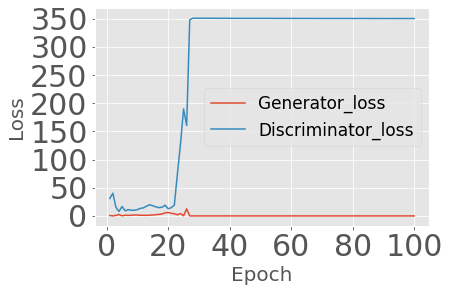

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(range(1, EPOCHS+1), gen_loss_tot , label='Generator_loss')
plt.plot(range(1, EPOCHS+1), disc_loss_tot , label= 'Discriminator_loss')

plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(prop={'size': 17})
plt.figure()

In [ ]:
#Comparing the generates samples and real ones
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
real_data=[]
synthetic_sample_size=2000
for d in iter(oos_train_loader):
  real_data+=d['input_encoding'].tolist()

real_data = np.array(real_data)

noise = torch.normal(mean=0, std=1.0, size=(synthetic_sample_size, input_length)) 
generated_data = generator(noise)




In [ ]:
real_data = pd.DataFrame(real_data)
real_data['label'] = 'real'

generated_data = pd.DataFrame(generated_data.detach().numpy())
generated_data['label'] = 'fake'

real_fake_data = pd.concat([real_data, generated_data])
X_embedded = TSNE(n_components=2).fit_transform(real_fake_data.loc[:, real_fake_data.columns != 'label'])


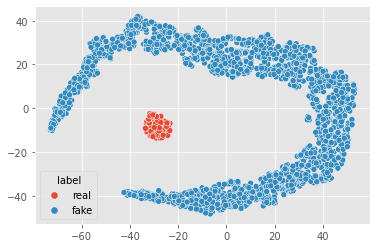

In [ ]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', hue = 'label', data= real_fake_data)

In [ ]:
#Data model class 
class SyntheticIntentDataset(Dataset):

  def __init__(self, noises, targets, model):
    self.noises = noises  #A request
    self.targets = targets  # An Intent
    self.model = model
    # self.max_len = max_len
    # self.encoding =''

  def __len__(self):
    return len(self.noises)

  def __getitem__(self, item):
    noise = self.noises[item]
    target = self.targets[item]
    encoding = self.model(
      noise
    )
    return {
      #'review_text': review,
      #'input_ids': encoding['input_ids'].flatten(),
      'input_encoding': encoding,
      # 'attention_mask': encoding['attention_mask'].flatten(),
      # 'token_type_ids' : encoding['token_type_ids'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)

    }
#-----------------------------------------------
def create_data_loader(noises, targets, model, batch_size):
  ds = SyntheticIntentDataset(
    noises=noises,
    targets=targets,
    model=model,
  )

  #Returning a Pytorch tensor
  return DataLoader(
    ds,
    batch_size=batch_size,
    sampler = RandomSampler(ds), # Select batches randomly
    #num_workers=1
  )

In [ ]:
BATCH_SIZE = 16
synthetic_sample_size = 200
noises = torch.normal(mean=0, std=1.0, size=(synthetic_sample_size, input_length)) 
generated_loader = create_data_loader(noises, np.zeros((1,synthetic_sample_size))[0], generator, BATCH_SIZE)

for uu in generated_loader:
  print(uu)
  break


{'input_encoding': tensor([[ 18.3998, -36.7371,   6.0535,  ...,  -2.4196,   4.1026, -40.2218],
        [ 18.3692, -36.1908,   5.9908,  ...,  -3.0056,   3.8879, -40.3311],
        [ 13.1388, -27.7101,   4.7392,  ...,  -2.1982,   2.8346, -31.2114],
        ...,
        [ 16.3525, -35.0251,   5.7443,  ...,  -3.2479,   3.4210, -38.4231],
        [ 17.3560, -33.9412,   6.3466,  ...,  -2.8286,   4.0624, -36.8791],
        [ 18.2548, -36.4380,   6.9912,  ...,  -2.4064,   4.4183, -39.9004]],
       grad_fn=<StackBackward>), 'targets': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


In [ ]:
#Creating MLP for classification
class MLP(nn.Module):
  def __init__(self,embedding_size, num_labels ):
        super().__init__()

        
        self.dense1 = nn.Linear(in_features= embedding_size, out_features= 500) 
        self.dense2 = nn.Linear(in_features= 500, out_features= num_labels) 
        self.activation= nn.ReLU()

  def forward(self, x):
        output = self.dense2 (self.activation(self.dense1(x)) )
 
        return output

mlp = MLP(input_length, num_labels)
mlp.cuda()

# Optimizers
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# loss
loss_mlp = nn.CrossEntropyLoss()


In [ ]:
losses=[]
train_loss=[]
val_loss_in=[]
val_loss_oos=[]
val_acc=[]
recall_scores=[]
EPOCHS =20
for i in tqdm(range(EPOCHS)):
  correct_predictions=0
  total_predictions = 0
  #Training on real and fake datasest
  for data_loader in [train_loader, generated_loader]:
  #for data_loader in [train_loader]:
    for mini_batch in iter(data_loader):
      x = mini_batch['input_encoding'].cuda()
      intent_labels = mini_batch['targets'].cuda()


      #Forward Propagation
      mlp_optimizer.zero_grad()
      outputs  = mlp(x)
      #print(outputs.logits.size())


      #Predicting the class lables
      preds = torch.argmax(outputs, dim=1)


      #Computing the loss function
      loss = loss_mlp(outputs, intent_labels)

      correct_predictions += torch.sum(preds == intent_labels)
      total_predictions +=  len(intent_labels)
      losses.append(loss.item())
      #break

      #Backward propagation
      loss.backward()

      #Update the weights
      mlp_optimizer.step()

  print("\n The loss value on training:", np.mean(losses))
  print("correct predictions and total predictions:", correct_predictions, total_predictions )
  #print("Prediction accuracy on training:", correct_predictions.double() / total_predictions )

  if(i%1==0):
    #Evaluating the model
    loss_in, acc = model_eval(mlp, val_loader, 'In-Scope')
    loss_oos, rec_score = model_eval(mlp, oos_val_loader, 'Out-Of-Scope')
    val_loss_in.append(loss_in); val_loss_oos.append(loss_oos); val_acc.append(acc); train_loss.append(np.mean(losses)); recall_scores.append(rec_score)
    mlp.train()

    if(val_loss_in[-1] <= np.min(val_loss_in)  and val_loss_oos[-1] <= np.min(val_loss_oos) ):
      print("Best model on validation is saved")
      torch.save(mlp.state_dict(),'/content/drive/My Drive/Deep Learing project/mlp(validation).m')



[1.2801756034931375, 0.8267915886452063, 0.6262267517958575, 0.5091279160334408, 0.43194857329654474, 0.3768432480187587, 0.3354036051430132, 0.30304967188888354, 0.2765886413270599, 0.25660138873403743, 0.23938030538138666, 0.22414214992999015, 0.21056139629567955, 0.19964686876130888, 0.19049300638094008, 0.18207043633518358, 0.1736902532825298, 0.16610638920246407, 0.1592938160118121, 0.1539442990539586]


<Figure size 432x288 with 0 Axes>

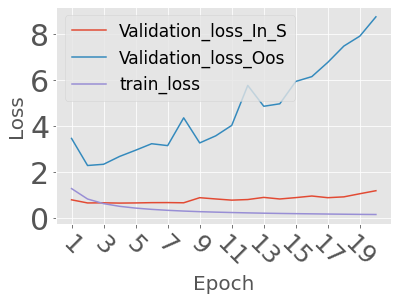

<Figure size 432x288 with 0 Axes>

In [ ]:
print(train_loss)
plt.plot(range(1, EPOCHS+1), val_loss_in, label = 'Validation_loss_In_S')
plt.plot(range(1, EPOCHS+1), val_loss_oos, label = 'Validation_loss_Oos')
plt.plot(range(1, EPOCHS+1), train_loss, label = 'train_loss')


plt.yticks(fontsize=30)
plt.xticks(np.arange(1,EPOCHS+1, step=2), fontsize=25, rotation = -45)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(prop={'size': 17})
#plt.title('BPI17',fontdict = {'fontsize' : 20})
plt.figure()

[1.2899984949513486, 0.8282177358137486, 0.6265459103701183, 0.5111757857213574, 0.43417127071065337, 0.379501806491446, 0.3376696485450809, 0.30712377962537696, 0.27926398325482044, 0.25867311606424953, 0.2431625935140064, 0.22679589177161477, 0.2122483915253788, 0.20079301912304365, 0.19202099333914113, 0.18296763046157047, 0.17474934446500645, 0.16775278103315933, 0.16114863840620433, 0.155754904084706]


<Figure size 432x288 with 0 Axes>

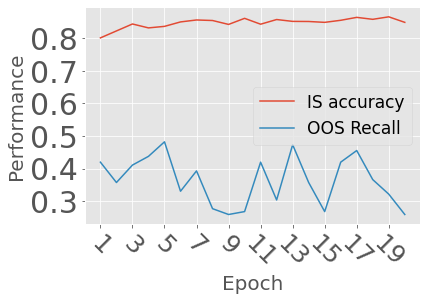

<Figure size 432x288 with 0 Axes>

In [ ]:
print(train_loss)
plt.plot(range(1, EPOCHS+1), val_acc, label = 'IS accuracy')
plt.plot(range(1, EPOCHS+1), recall_scores, label = 'OOS Recall')


plt.yticks(fontsize=30)
plt.xticks(np.arange(1,EPOCHS+1, step=2), fontsize=25, rotation = -45)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Performance', fontsize=20)
plt.legend(prop={'size': 17})
#plt.title('BPI17',fontdict = {'fontsize' : 20})
plt.figure()

In [ ]:
def model_eval(model, data_loader, mode):
  '''
  A method for model evaluation.
  '''
  inp={}
  
  #Turning on the evaluation mode
  model.eval()

  losses = []
  correct_predictions = 0    #Number of correct predcitions
  total_predictions=0        #Total number of predictions
  recall_scores=[]
  for mini_batch in iter(data_loader):
      x = mini_batch['input_encoding'].cuda()
      intent_labels = mini_batch['targets'].cuda()
    
      #Forward Propagation
      mlp_optimizer.zero_grad()
      outputs  = mlp(x)
      #print(outputs.logits.size())


      #Predicting the class lables
      preds = torch.argmax(outputs, dim=1)



      loss = loss_mlp(outputs, intent_labels)
      losses.append(loss.item())
      if(mode == 'In-Scope'):
        #Computing the loss function
        # print('preds:', preds)
        # print('intetns:', intent_labels)
        #loss = loss_mlp(outputs, intent_labels)
        correct_predictions += torch.sum(preds == intent_labels)
        total_predictions +=  len(intent_labels)
        #losses.append(loss.item())

      elif(mode =='Out-Of-Scope'):
        # print('preds:', preds)
        # print('intetns:', intent_labels)
        #preds[preds>0]=1

        preds= preds.tolist()
        intent_labels = intent_labels.tolist()
        OOS_recall = np.sum(np.array(preds == np.array(intent_labels)))/len(preds)   #computing Precision
        recall_scores.append(OOS_recall)


  if(mode == 'In-Scope'):
    print("\n The loss value on evaluation In-scope:", np.mean(losses))
    print("correct predictions and total predictions on validation:", correct_predictions, total_predictions )
    print("Prediction accuracy on evaluation:", correct_predictions.double() / total_predictions )
    return np.mean(losses), correct_predictions.double() / total_predictions

  elif(mode =='Out-Of-Scope'):
    print("\n The recall for Out-Of-Scope Intents:", np.mean(recall_scores))
    print("The loss value on evaluation Out-of_scope:", np.mean(losses))
    return np.mean(losses), np.mean(recall_scores)

  


#Loading the best model
path = '/content/drive/My Drive/Deep Learing project/mlp(validation GAN).m'
mlp.load_state_dict( torch.load(path))
mlp_validation = mlp
mlp_validation.eval()



model_eval(mlp_validation, test_loader, 'In-Scope')
model_eval(mlp_validation, oos_test_loader, 'Out-Of-Scope')


 The loss value on evaluation In-scope: 0.7778968645642835
correct predictions and total predictions on validation: tensor(3531, device='cuda:0') 4500
Prediction accuracy on evaluation: tensor(0.7847, device='cuda:0', dtype=torch.float64)

 The recall for Out-Of-Scope Intents: 0.49503968253968256
The loss value on evaluation Out-of_scope: 1.871578025439429


(1.871578025439429, 0.49503968253968256)

tensor([117], device='cuda:0')